# SNPE & RF

learning receptive field parameters from inputs (white-noise videos) and outputs (spike trains) of linear-nonlinear neuron models with parameterized linear filters

In [1]:
%%capture
%matplotlib inline
# notebook currently depends on code found only in feature_maprf-branch of lfi_models !

import delfi.neuralnet as dn
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import matplotlib.pyplot as plt
import numpy as np
import lfimodels.maprf.utils as utils

from lfimodels.maprf.maprfModel import maprf
from lfimodels.maprf.maprfStats import maprfStats
from delfi.utils.viz import plot_pdf

import lasagne.layers as ll
import theano
import theano.tensor as tt
import collections


In [2]:
def create_prior(m):
    ## prior over simulation parameters
    prior = collections.OrderedDict()
    
    if 'bias' in m.params_ls['glm']:
        prior['λo'] = {'mu' : np.array([-0.57]), 'sigma' : np.array([np.sqrt(1.63)]) }
    if 'vec_A' in m.params_ls['kernel']['s']:
        prior['vec_A']  = {'mu' : np.zeros(2), 'sigma' : 1.0 * np.ones(2) }
    if 'gain' in m.params_ls['kernel']['s']:
        prior['float_A'] = {'mu' : np.array([0]), 'sigma' : np.array([1.])}  
    if 'phase' in m.params_ls['kernel']['s']:
        prior['logit_φ']  = {'mu' : np.array([0]), 'sigma' : np.array([1.78]) }    
    if 'vec_f' in m.params_ls['kernel']['s']:
        prior['vec_f']  = {'mu' : np.zeros(2), 'sigma' : 1.0 * np.ones(2) }
    if 'ratio' in m.params_ls['kernel']['s']:
        prior['log_γ']  = {'mu' : np.array([-0.098]), 'sigma' : np.array([0.256])}
    if 'width' in m.params_ls['kernel']['s']:
        prior['log_b']  = {'mu' : np.array([ 0.955]), 'sigma' : np.array([0.236])}
    if 'xo' in m.params_ls['kernel']['l']:
        prior['xo'] = {'mu' : np.array([0.]), 'sigma' : np.array([1/np.sqrt(.5)])}
    if 'yo' in m.params_ls['kernel']['l']:
        prior['yo'] = {'mu' : np.array([0.]), 'sigma' : np.array([1/np.sqrt(.5)])}    
        
    L = np.diag(np.concatenate([prior[i]['sigma'] for i in list(prior.keys())]))
    
    if 'value' in m.params_ls['kernel']['t']:
        ax_t = m.dt * np.arange(1,len_kt+1)
        Λ =  np.diag(ax_t / 0.075 * np.exp(1 - ax_t / 0.075))
        D = np.eye(ax_t.shape[0]) - np.eye(ax_t.shape[0], k=-1)
        F = np.dot(D, D.T)
        Σ = np.dot(Λ, np.linalg.inv(F).dot(Λ))
        prior['kt'] = {'mu': np.zeros_like(ax_t), 'sigma': np.linalg.inv(D).dot(Λ)}
        L = np.block([[L, np.zeros((L.shape[0], ax_t.size))], 
                      [np.zeros((ax_t.size, L.shape[1])), prior['kt']['sigma']]])
        
    mu  = np.concatenate([prior[i][ 'mu'  ] for i in prior.keys()])
    
    return dd.Gaussian(m=mu, S=L.T.dot(L), seed=seed)

In [3]:
def plot_draws(m, p, name, x = 5, y = 3):
    fig, axes = plt.subplots(y, x, figsize=(x * 2, y * 2))
    
    for i in range(x):
        for j in range(y):
            ax = axes[j][i]
            if i > 0:
                ax.set_yticks([])
            if j < y - 1:
                ax.set_xticks([])
            ax.imshow(m.params_to_rf(p.gen().reshape(-1))[0], interpolation='None')
            
    fig.suptitle('RF {} draws'.format(name))
    plt.show()
    
    return fig, axes

def plot_weird_stuff(m, p, obs_stats, true_params, posterior=None):
    if posterior is not None:
        fig, axes = plt.subplots(1, 5, figsize=(10,2))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(6,2))
        
    axes[0].imshow(m.params_to_rf(p.mean)[0], interpolation='None')
    axes[0].set_title('prior mean RF')
    axes[1].imshow(obs_stats.reshape(d,d), interpolation='None')
    axes[1].set_title('data STA')
    axes[1].set_yticks([])
    axes[2].imshow(m.params_to_rf(true_params)[0], interpolation='None')
    axes[2].set_title('ground-truth RF')
    axes[2].set_yticks([])
    
    if posterior is not None:
        axes[3].imshow(m.params_to_rf(posterior.calc_mean_and_cov()[0])[0], interpolation='None')
        axes[3].set_title('posterior mean RF')
        axes[3].set_yticks([])
        a_max = np.argmax(posterior.a)
        axes[4].imshow(m.params_to_rf(posterior.xs[a_max].m)[0], interpolation='None')
        axes[4].set_title('posterior mode RF')
        axes[4].set_yticks([])

    plt.show()
    
    return fig, axes

def plot_posterior_contours(m, posterior):
    plt.figure(figsize=(6,6))
    plt.imshow(obs_stats.reshape(d,d), interpolation='None', cmap='gray')
    for i in range(100):
        rfm = m.params_to_rf(posterior.gen().reshape(-1))[0]
        plt.contour(rfm, levels=[-0.1, 0.1])
        plt.hold(True)
    plt.title('RF posterior draws')
    plt.show()

In [32]:
seed = 42

## simulation model

d = 42 # edge length of (quadratic) receptive field
parametrization = 'gabor' # ['full', 'gaussian', 'gabor']
len_kt = 2

params_ls = {'glm': ('bias',),
             'kernel': {'s' : ('gain', 'phase', 'vec_f', 'ratio', 'width'),
                        'l' : [],
                        't' : []}}

filter_shape = np.array((d,d,2))

In [34]:
n_hiddens =(50,50)
n_filters = (24,24)
n_train=100
epochs=100
minibatch=50
n_rounds=5
n_components=1

In [35]:
def run_sim(alpha = 0):
    m = maprf(filter_shape=filter_shape, 
              parametrization=parametrization,
              params_ls = params_ls,
              seed=seed, 
              dt=0.025, 
              duration=60)

    p = create_prior(m)
    s = maprfStats(n_summary=d*d)
    g = dg.Default(model=m, prior=p, summary=s)
    
    
    params_dict_true = {'glm': {'binsize': m.dt,
                                'bias': 1.54546216004078},
                                'kernel': {'s': {'angle': 0.7,
                                         'freq': 1.2,
                                         'gain': 0.357703095858336,
                                         'phase': np.pi/4,
                                         'ratio': 1.,
                                         'width': 2.5},
                                   'l': {'xo': 0.,
                                         'yo': 0.},
                                   't': {'value': np.array([1., 0.])}}}

    m.params_dict = params_dict_true
    true_params = m.read_params_buffer()

    obs = m.gen_single()
    obs_stats = s.calc([obs])

    
    inf = infer.SNPE(generator=g, obs=obs_stats, prior_norm=False, pilot_samples=None, seed=seed, reg_lambda=0,
                     n_components=n_components, n_hiddens=n_hiddens, 
                     prior_mixin=alpha, n_filters=n_filters, n_inputs = (1,d,d), svi=True)

    logs, tds, posteriors = inf.run(n_train=n_train, epochs=epochs, minibatch=minibatch, n_rounds=n_rounds)

    posterior = inf.predict(obs_stats)
    posterior.ndim = posterior.xs[0].ndim
    
    return { 'model' : m, 'prior' : p, 'posteriors' : posteriors, 
             'obs_stats' : obs_stats, 'true_params' : true_params }


In [36]:
sim_list = {}
alphas = [ 0, 0.01, 0.03, 0.1 ]

for alpha in alphas:
    sim_list[alpha] = run_sim(alpha=alpha)

In [39]:
def plot_variances(posteriors, title = None, n_samples = 10000):
    varlist = []
    for p in posteriors:
        samples = p.gen(n_samples)
        means = [ np.mean(x) for x in samples.T ]
        var = [ np.mean((x - m) ** 2) for x, m in zip(samples.T, means) ]
        varlist.append(var)
        
    ylists = np.asarray(varlist).T
    fig, ax = plt.subplots(1, figsize=(8,4))
    
    if title is not None:        
        fig.suptitle(title)
        
    xlist = np.arange(len(posteriors))
    
    for ylist in ylists:
        ax.semilogy(xlist, ylist)
        
    ax.set_xticks(xlist)
    
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Posterior Variance")
    
    plt.show()
    return fig    

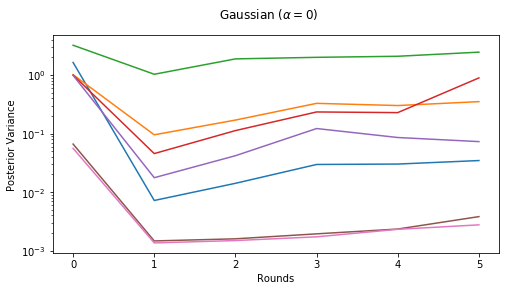

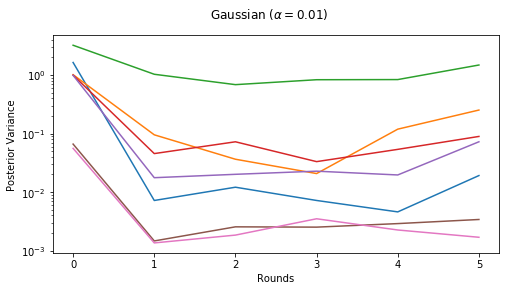

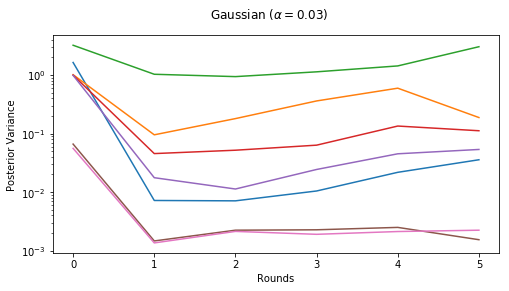

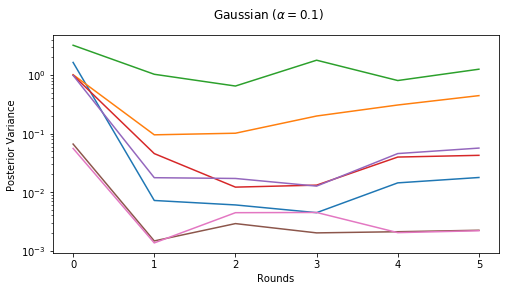

In [40]:
for alpha in alphas:
    data = sim_list[alpha]
    model = data['model']
    prior = data['prior']
    posteriors = data['posteriors']
    true_params = data['true_params']

    obs_stats = data['obs_stats']
    posterior = posteriors[-1]

    #plot_draws(model, prior, "prior")
    #plot_weird_stuff(model, prior, obs_stats, true_params)

    #for p in posteriors:
        #plot_draws(model, p, "posterior")

    plot_variances([prior] + posteriors, "Gaussian ($\\alpha = {}$)".format(alpha))
    # all pairwise marginals of fitted posterior
    #plot_pdf(posterior, pdf2=prior, lims=[-3,3], gt=true_params.reshape(-1), figsize=(8,8), 
     #        labels_params=['exp_b', 'vec_A1', 'vec_A2', 'vec_f1', 'vec_f2', 'log ratio', 'log width'])